# Bechdel Test Analysis
This code file builds upon the findings in the FiveThirtyEight article looking at movie income and budget in relation to their Bechdel Test Status. (https://fivethirtyeight.com/features/the-dollar-and-cents-case-against-hollywoods-exclusion-of-women/)

The Bechdel test is a test of women's representation in films named after cartoonist Alison Bechdel.

In order to pass the Bechdel test, a movie needs to have:
1. 2 named female characters
2. These characters need to speak to each other during the movie
3. The conversation needs to be about something other than a man

FiveThirtyEight showed in their analysis that movies that passed the Bechdel Test were given less of a budget than movies that failed the Bechdel Test, however they grossed no less upon release.

While money is the obvious motivator for Hollywood, the motivator for viewers can be seen as the rating of the movie. By merging the FiveThirtyEight Bechdel dataset with an IMDb dataset of movie ratings I was able to ask whether movies that passed the Bechdel test were rated any different from movies that failed. 

In this file you will be able to see:
1. The preprocessing of the data
2. A replication of the FiveThirtyEight results
3. An analysis of ratings by Bechdel Test status
4. Conclusions and future directions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

## Preprocessing

### Loading Data
If you are running this file for yourself make sure that the following paths are correct.

In [2]:
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/IMDb_ratings.csv')
inflation = pd.read_csv('data/CPIAUCNS_inflation.csv')

### Cleaning and Merging
ID columns needed to be renamed to match across datasets so they can be merged

In [3]:
movies = movies.rename(columns = {'imdb':'title_id'})
ratings = ratings.rename(columns ={'imdb_title_id' : 'title_id'})

In [4]:
data = movies.merge(ratings, on = 'title_id')

In [5]:
data.columns

Index(['year', 'title_id', 'title', 'test', 'clean_test', 'binary', 'budget',
       'domgross', 'intgross', 'code', 'budget_2013$', 'domgross_2013$',
       'intgross_2013$', 'period code', 'decade code', 'weighted_average_vote',
       'total_votes', 'mean_vote', 'median_vote', 'votes_10', 'votes_9',
       'votes_8', 'votes_7', 'votes_6', 'votes_5', 'votes_4', 'votes_3',
       'votes_2', 'votes_1', 'allgenders_0age_avg_vote',
       'allgenders_0age_votes', 'allgenders_18age_avg_vote',
       'allgenders_18age_votes', 'allgenders_30age_avg_vote',
       'allgenders_30age_votes', 'allgenders_45age_avg_vote',
       'allgenders_45age_votes', 'males_allages_avg_vote',
       'males_allages_votes', 'males_0age_avg_vote', 'males_0age_votes',
       'males_18age_avg_vote', 'males_18age_votes', 'males_30age_avg_vote',
       'males_30age_votes', 'males_45age_avg_vote', 'males_45age_votes',
       'females_allages_avg_vote', 'females_allages_votes',
       'females_0age_avg_vote', 'females

The inflation dataset contains the Consumer Price Index (CPI) for every month since 1918. This value is used as an aproximation of the price of consumer goods. By dividing the latest CPI with the CPI for every year previous we get an Inflation Multiplier. By applying the multiplier value of the year of movie release to the relevant monetary values we can compare budget and income across years.

In [6]:
inflation['multiplier'] = inflation['CPIAUCNS'].iloc[-1] / inflation['CPIAUCNS']
inflation['DATE'] = pd.to_datetime(inflation['DATE'])
inflation['year'] = inflation['DATE'].apply(lambda x: x.year)
inflation_simple = inflation.drop_duplicates(subset = 'year', keep = 'first')

In [7]:
data_full = pd.merge(data, inflation_simple, on = ['year'])
data_full['domgross_adjusted'] = data_full['domgross'] * data_full['multiplier']
data_full['intgross_adjusted'] = data_full['intgross'] * data_full['multiplier']
    
data_full['budget_adjusted'] = data_full['budget'] * data_full['multiplier']
data_full['total_gross'] = data_full['domgross'] + data_full['intgross']
data_full['total_gross_adjusted'] = data_full['domgross_adjusted'] + data_full['intgross_adjusted']

In [8]:
# Removing movies with no budget information and extreme outliers
data_clean = data_full.dropna(inplace = False, axis = 0, subset = ['budget_adjusted', 'domgross_adjusted'])
budget_z = np.abs(stats.zscore(data_clean['budget_adjusted']))
domgross_z = np.abs(stats.zscore(data_clean['domgross_adjusted']))

data_clean = data_clean[(budget_z < 3) & (domgross_z < 3) & (data_clean['year'] > 1990)]

## Replication

Text(0.5, 0.98, 'Domestic Gross Income (Unadjusted for Inflation)')

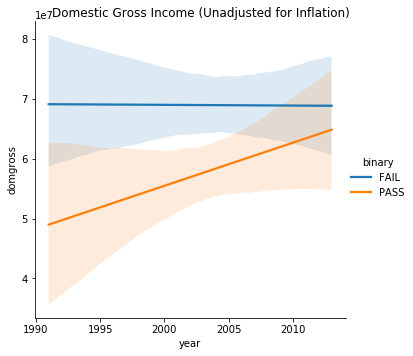

In [9]:
a = sns.lmplot(data = data_clean, x = 'year', y = 'domgross', markers = 'x', hue = 'binary', scatter = False)
plt.suptitle("Domestic Gross Income (Unadjusted for Inflation)")

The following plots show the monetary features of the movies by year, separated by Bechdel Status. The budget plot is consistent with the results of the FiveThirtyEight article showing that the movies that Fail the Bechdel Test consistently get a higher budget. The Income Plot shows a strong negative slope, with all movies decreasing in income. This can be explained by older movies having decades more time to increase their income. As well as the inflation multiplier for their year of release being blanket applied when they likely continued to make income in subsequent years with different inflation multipliers. Since their income is not broken down by year in the datasets available there is no way to correct for this.

Text(0.5, 0.98, 'Movie Domestic Income by Year by Bechdel Status')

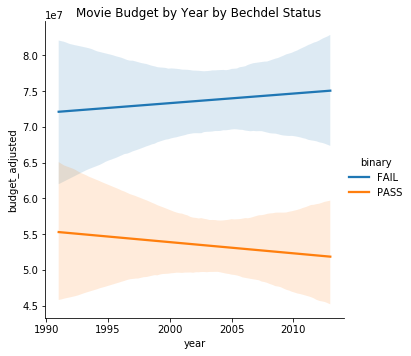

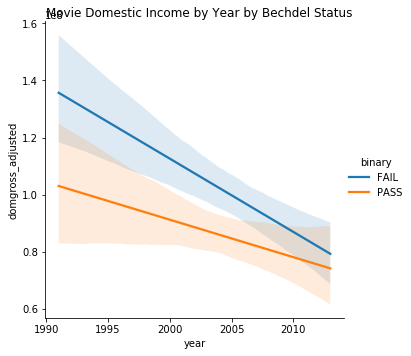

In [10]:
bug = sns.lmplot(data = data_clean, x = 'year', y = 'budget_adjusted', markers = 'x', hue = 'binary', scatter = False)
plt.suptitle("Movie Budget by Year by Bechdel Status")
gross = sns.lmplot(data = data_clean, x = 'year', y = 'domgross_adjusted', markers = 'x', hue = 'binary', scatter = False)
plt.suptitle("Movie Domestic Income by Year by Bechdel Status")

In order to confirm these plots, I used the original 538 monetary columns to see if they had the same results with their adjustsments. Their plots showed the same trends. This confirmed that the monetary calculations were correct, and it replicated the findings in the original article.

Text(0.5, 0.98, 'Movie Domestic Income by Year by Bechdel Status')

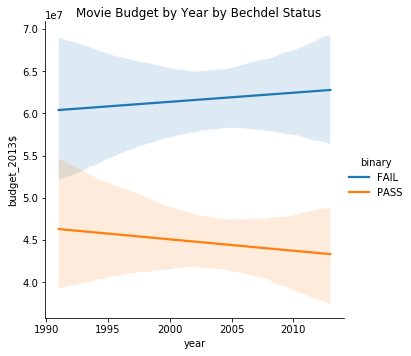

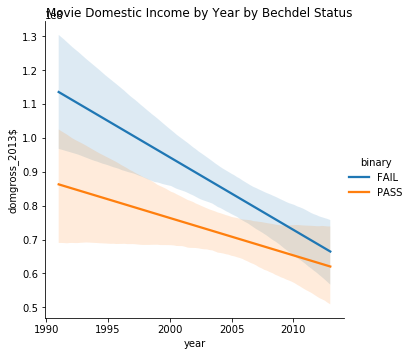

In [11]:
bug = sns.lmplot(data = data_clean, x = 'year', y = 'budget_2013$', markers = 'x', hue = 'binary', scatter = False)
plt.suptitle("Movie Budget by Year by Bechdel Status")
gross = sns.lmplot(data = data_clean, x = 'year', y = 'domgross_2013$', markers = 'x', hue = 'binary', scatter = False)
plt.suptitle("Movie Domestic Income by Year by Bechdel Status")

Next I wanted to look at the monetary distributions, split by Bechdel Status. This KDE plot highlights the differences in the income and budget. While all movies have similar peaks, the movies that fail the Bechdel test have a wider spread of both budget and income.

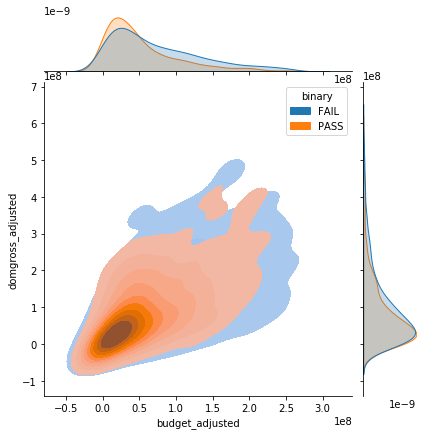

In [12]:
sns.jointplot(data = data_clean, x = 'budget_adjusted', y = 'domgross_adjusted', \
              hue = 'binary', kind = 'kde', fill = True)

Next I wanted to do a similar plot to the original article and separate the budget and income by specific Bechdel Satus, rather than the binary Pass or Fail. These plots confirm the original article, Failed Bechdel Test movies recieve a higher budget, and have a much less noticiable difference in their incomes.

**KEY**\
ok: PASS\
dubious: Grey area, hard to come to a consensus\
men: The women in the movie only talked about men\
notalk: The female characters never spoke\
nowomen: There were less than 2 female characters

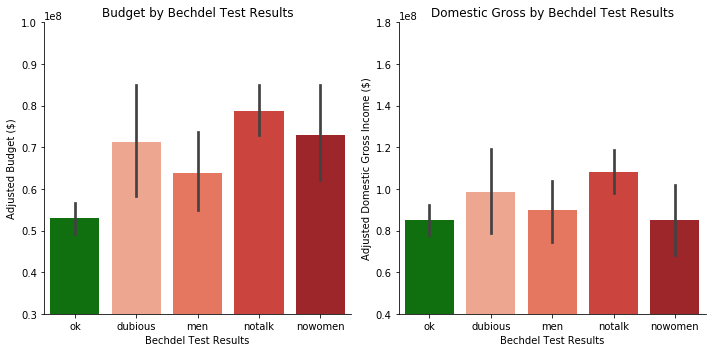

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
hue_order = ['ok',  'dubious', 'men', 'notalk', 'nowomen' ]
colors = sns.color_palette("Reds", 5)
colors [0] = 'green'
sns.barplot(data = data_clean, x = 'clean_test', y = 'domgross_adjusted', ax = ax[1], palette = colors, order = hue_order)
sns.barplot(data = data_clean, x = 'clean_test', y = 'budget_adjusted', ax = ax[0], palette = colors, order = hue_order)

ax[0].set_title('Budget by Bechdel Test Results')
ax[1].set_title('Domestic Gross by Bechdel Test Results')

ax[0].set_ylim((3e7, 1e8))
ax[1].set_ylim((4e7, 1.8e8))

ax[0].set_ylabel('Adjusted Budget ($)')
ax[1].set_ylabel('Adjusted Domestic Gross Income ($)')
ax[0].set_xlabel('Bechdel Test Results')
ax[1].set_xlabel('Bechdel Test Results')


plt.tight_layout()
sns.despine()

## Rating Analysis
After confirming the results of the original article I did new analysis on the movies looking specifically at the ratings of the movies and the Bechdel results.

In [14]:
# only some of the columns are relevant
rates_simple = data_clean[['title_id','clean_test', 'binary', 'weighted_average_vote', 'males_allages_avg_vote', 'females_allages_avg_vote']]

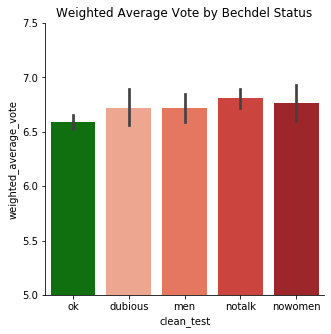

In [15]:
hue_order = ['ok',  'dubious', 'men', 'notalk', 'nowomen' ]
colors = sns.color_palette("Reds", 5)
colors [0] = 'green'

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = [5, 5])
a = sns.barplot(data = rates_simple, x = 'clean_test', y = 'weighted_average_vote', ax = ax, palette = colors, order = hue_order)
ax.set_ylim((5,7.5))
ax.set_title('Weighted Average Vote by Bechdel Status')
sns.despine()

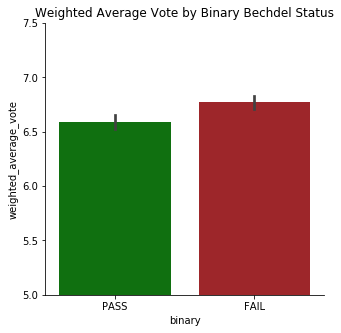

In [16]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = [5, 5])
pal = ['green', colors[-1]]
a = sns.barplot(data = rates_simple, x = 'binary', y = 'weighted_average_vote', ax = ax, palette = pal, order = ['PASS', 'FAIL'])
ax.set_ylim((5,7.5))
ax.set_title('Weighted Average Vote by Binary Bechdel Status')
sns.despine()

In order to check if this was a statistically significant difference, I ran a one-way ANOVA. With a p_value of less than 0.05 (*p=0.002*) we can reject the null-hypothesis that there is no different between the mean ratings of these groups.

In [17]:
from scipy import stats

ok = rates_simple[rates_simple['clean_test']=='ok']
dubious = rates_simple[rates_simple['clean_test']=='dubious']
men = rates_simple[rates_simple['clean_test']=='men']
notalk = rates_simple[rates_simple['clean_test']=='notalk']
nowomen = rates_simple[rates_simple['clean_test']=='nowomen']


fvalue, pvalue = stats.f_oneway(ok['weighted_average_vote'], dubious['weighted_average_vote'], men['weighted_average_vote'], notalk['weighted_average_vote'], nowomen['weighted_average_vote'])

print('Fvalue::', fvalue,'P-value:', pvalue)

Fvalue:: 4.3259259147594396 P-value: 0.001753452877454312


In order to look closer at these findings, I ran a similar analysis while separating men and womens votes. 

In [18]:
rates_simple_melt = pd.melt(rates_simple, id_vars = ['title_id', 'clean_test', 'binary'], value_vars = ['males_allages_avg_vote', 'females_allages_avg_vote'], var_name = 'group', value_name = 'rating')

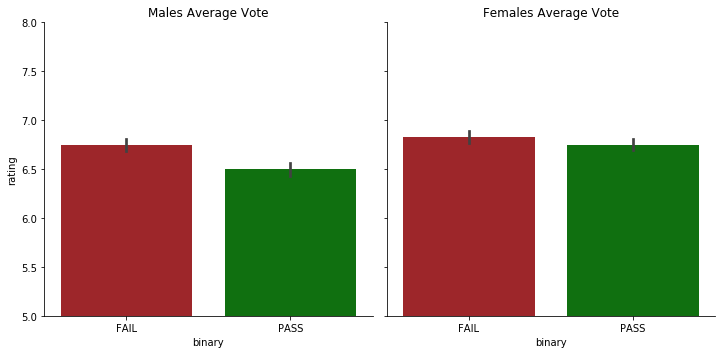

In [19]:
colors1 = {'males_allages_avg_vote':'#5B6FF9',
            'females_allages_avg_vote':'#FFF66C'}
colors2 = {'PASS':'green',
            'FAIL':colors[-1]}
g = sns.catplot(data = rates_simple_melt, x = 'binary', y = 'rating', col = 'group', kind = 'bar', palette = colors2)
g.axes[0][0].set_ylim((5,8))
_ = g.axes[0][0].set_title('Males Average Vote')
_ = g.axes[0][1].set_title('Females Average Vote')

The interesting finding from this analysis is women rate all movies very similarly, while men rate movies that pass the Bechdel test lower than movies that fail it. In order to test if this is a statistically significant finding I ran a two sample t-test. 

The results were that the mean ratings by women were not any different based on their Bechdel status (*p=0.06*). While the mean ratings by men were statistically lower for movies that failed the Bechdel test (*p=1.3e-7*)

In [20]:

men_vote_pass = rates_simple[rates_simple['binary']=='PASS']['males_allages_avg_vote']
fem_vote_pass = rates_simple[rates_simple['binary']=='PASS']['females_allages_avg_vote']

men_vote_fail = rates_simple[rates_simple['binary']=='FAIL']['males_allages_avg_vote']
fem_vote_fail = rates_simple[rates_simple['binary']=='FAIL']['females_allages_avg_vote']

ratmen = stats.ttest_ind(men_vote_pass, men_vote_fail)
ratwomen = stats.ttest_ind(fem_vote_pass, fem_vote_fail)

In [21]:
print('ttest men: ', ratmen)
print('ttest women:', ratwomen)

ttest men:  Ttest_indResult(statistic=-5.303169118371927, pvalue=1.3046345600792866e-07)
ttest women: Ttest_indResult(statistic=-1.8175657398972123, pvalue=0.06932592053544909)


## Conclusions

The conclusions that can be drawn from this addition to the FiveThirtyEight findings are that movies do recieve different ratings based on their Bechdel test status. This difference can be at least in part explained by the difference in mens and womens average votes. Men vote movies that pass the Bechdel test lower than movies that fail it, while women vote the movies the same regardless of Bechdel test status.

This finding is interesting when you combine it with the budgets the movies recieve. Since many industries, the movie industry included, are dominated by men, it makes sense that they would reward movies they don't think they'll like with a lower budget. However, this ignores half the population. As society inches towards equality it's important to consider all audiences when creating a product. Movies are no exception.

Future studies in this area could look closer at the differnces between men and womens votes including the trends over time could also be analyzed since women play a larget part in society now than they did in the 1900's. A more accurate way to look at income in relation to inflation should also be determined to ensure that the conclusions are accurate and not a result of a snowball effect over time.